**Bigram Model for Protein Sequence Generation**

**Author:** Jamie Upadhyaya  
**LinkedIn:** [linkedin.com/in/jamieupadhyaya](https://linkedin.com/in/jamieupadhyaya)  


## **[Open in Colab](https://colab.research.google.com/drive/17IAJmcutCab5pjZgkDAbjjFkoS7gu4Ev?usp=drive_link) for the full visual experience**

# ***Welcome***

This walkthrough is a simple introduction to create and visualize novel proteins. The creation is done in two parts.

1. Build a **bigram model** to generate new protein sequences an amino acid at a time.
2. Use **AlphaFold3** to visualize the 3D structures into which these sequences fold.

By the end you will have a newly minted, novel protein structure. This lesson is designed to be a quickstart so we can focus on the fun of creation without getting stuck on details. We will dive deeper into machine learning and molecular biology in future lessons.

> To quickly skip around this colab notebook, access the table of contents at the top-left corner of your screen.



# Goals
- To understand and implement the bigram model
- Generate novel protein sequences with the bigram model
- Use AlphaFold3 to predict the 3D structure of bigram-generated protein sequences  

> Take a minute to play with AlphaFold3 at alphafoldserver.com!

# Tasks

Our protein design process will undertake three stages.

1. Data
  - download biological sequences
  - extract amino acid sequences

2. Bigram Model Learning
  - identify amino acids present in dataset
  - create an amino acid - integer converter
  - create an integer - amino acid converter
  - collect observed pairs of amino acids
  - count amino acid pairs
  - store counts of amino acid pairs in a table
  - transform counts into measures of chance              

3. Generation
  - spell amino acid sequences using the bigram model
  - predict 3D protein structure given its amino acid sequence with AF3

# ***Data***
_Extracting amino acid sequences from the Protein Data Bank_

Observe the first ten rows of sequence data from the Protein Data Bank.
```
>100d_A mol:na length:10  DNA/RNA (5'-R(*CP*)-(*CP*GP*GP*CP*GP*CP*CP*GP*)-R(*G)-3')
CCGGCGCCGG
>100d_B mol:na length:10  DNA/RNA (5'-R(*CP*)-D(*CP*GP*GP*CP*GP*CP*CP*GP*)-R(*G)-3')
CCGGCGCCGG
>101d_A mol:na length:12  DNA (5'-D(*CP*GP*CP*GP*AP*AP*TP*TP*(CBR)P*GP*CP*G)-3')
CGCGAATTCGCG
>101d_B mol:na length:12  DNA (5'-D(*CP*GP*CP*GP*AP*AP*TP*TP*(CBR)P*GP*CP*G)-3')
CGCGAATTCGCG
>101m_A mol:protein length:154  MYOGLOBIN
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
```
Each record is formatted as a header and sequence pair as shown below.
```
Header
Sequence
Header
Sequence
.
.
.
Header
Sequence
```

Headers containing the field ```mol:protein``` indicate that the following line is a protein sequence we wish to extract.

```
>101m_A mol:protein length:154  MYOGLOBIN
MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
```

>**IMPORTANT**: We will need the **T4 GPU** for this lesson. Make sure the **T4 Runtime** is selected before executing code cells. At the top select **Runtime** >> **Change Runtime type** then choose **T4 GPU** and save.

## **Get Dataset**
 Download the Protein Data Bank sequence dataset.

> Run a cell by selecting it and pressing **Shift + Enter** or by clicking the play button in the top left of the cell

In [ ]:
import urllib.request
import gzip

# Protein Data Bank Sequence URL
url = "https://files.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt.gz"

# Downloads and opens the sequence file
with urllib.request.urlopen(url) as response:
    with gzip.GzipFile(fileobj=response) as gz_file:
        content = gz_file.read().decode("utf-8")

# Loads file lines as a list of items
data = content.splitlines()

# Peeks at the first ten lines
data[:10]


> Get an explanation of the code by clicking the 3 vertical dots at the top-right corner of a cell and selecting _Explain code_.

> **I recommend pasting the code into ChatGPT for detailed code explanations.**


## **Clean Data**

We do not want all the sequence data from Protein Data Bank; only the amino acid sequences. By reading the ```mol``` field from each header we can identify and extract our target sequences.

In [ ]:
# Initialize an empty list to store protein sequences
sequences = []

# Flag signaling protein sequence
found_protein = False

# Loop through dataset to load protein sequences into list
for iterator in range(len(data)):

  # Access data
  line = data[iterator]

  # Add protein sequence to list
  if found_protein == True:
    sequences.append(line)
    found_protein = False

  # If header has mol:protein set flag to True
  if line.startswith('>'):
    header = line.split()
    mol_type = header[1]
    if mol_type == "mol:protein":
      found_protein = True


Now we can see how large our dataset is and what it looks like.

In [ ]:
print(f'We have {len(sequences)} amino acid sequences in our dataset that look like:')
sequences[:5]

# ***Bigram Model***
_Learning from the previous amino acid_

The bigram ```MM``` makes up the sequence ```MMMMMM``` and conversely the sequence ```MMMMMM``` is made of the bigram ```MM```.

> Hereafter we will refer to amino acids as **tokens**. Tokens are our atoms in generative models and since we are building amino acid sequences, amino acids are our tokens.

## Bigrams: Amino Acid Pairs

The following protein sequence ```.MADAMA.``` can be split into the bigrams ```.M, MA, AD, DA, AM, MA, A.``` . Each bigram has a first token (first amino acid) and a second token (second amino acid). We will need to count these bigrams and store them in a table. This means each bigram needs to be placed in a unique row-column location which requires some kind of token to integer translation.

**Review**: Observe from the bigrams above that if we start with the amino-acid token A (Alanine) then we have a 50% chance that D (Aspartic Acid) follows and a 50% chance that M (Methionine) follows. If we start with Methionine then we are guaranteed to have A (Alanine) follow it. We spell new sequences by sampling (drawing) from these distributions which are the envelopes in our raffle.

You may wonder why there is a ```.``` at the beginning and end of the sequence. This is an artifical **start-stop token** that we add in order to represent the start token and end token of our amino acid sequence. We subsequently add the ```.``` token to our token set. The start-stop token allows us to select the first amino acid in our sequence and allows us to select the final amino acid in our sequence.


1. The start ```.``` is the distribution of next-tokens that initiate our amino acid sequence.
2. The end ```.``` is the token that terminates the sampling process when it is drawn.


## Token to Integer Encoder and Decoder

1. Token-to-Integer encoder allows us to store our bigrams in a matrix because matrices need integers to refer to rows and columns.
2. Decoder reverses the encoding and allows us to identify the tokens that are associated with a specific matrix cell during the sampling process.


The following code cell combines all amino acid sequences in our ```sequences``` list into one, extremely lengthy sequence. This long sequence is passed into the **set** function removing redundant amino acids which results in a set of unique tokens that is our amino acid alphabet.

In [ ]:
tokens = list(set(''.join(sequences)))
tokens

> Keep in mind whenever you run the set function the order of the elements changes.





By associating a unique integer with each token in a bigram then the pair of integers describe a row-column location where each bigram count can be stored. In one line we can initialize token-to-integer **encoder** in a set of key-value pairs called a dictionary.

In [ ]:
tokint = {token:integer + 1 for integer,token in enumerate(tokens)}
tokint

Remember, we still have to add our start-stop token which is why we had reserved the value zero in ```tokint```.

In [ ]:
# Adds . to our token set and associates it with the index 0
tokint['.'] = 0


We will also reverse the mapping from integer to tokens which allows us to decode our bigram frequencies stored in our table back into our amino acid tokens. This helps us during our generation process so we can use random number generation to select a possible next token from our matrix. This is our **decoder**.

In [ ]:
# Reverses the mapping of tokint
intok = {integer:token for token,integer in tokint.items()}
intok

## Create and Count Bigrams

We must count our bigrams, and store them in the correct matrix location in preparation for normalization.

Step 1: Create our row-column matrix which is called ```bigram_counts```. Initialize all bigram counts with zeros and set the number of rows and number of columns equal to the token count.

> Our token count is the total number of amino acids plus our artificial token.

In [ ]:
import torch

# initialize a matrix with all zeros with number of rows and columns equal to number of tokens
bigram_counts = torch.zeros((len(tokint.keys()),len(tokint.keys())), dtype=torch.int32)


import matplotlib.pyplot as plt
%matplotlib inline

# Plot our zero matrix in a formatted table
plt.figure(figsize=(26,26))
plt.imshow(bigram_counts.cpu(), cmap='Greens')
for i in range(len(tokint)):
  for j in range(len(tokint)):
    chstr = intok[i] + intok[j]
    plt.text(j,i,chstr,ha='center',va='bottom',color='BLACK')
    plt.text(j,i,f'{bigram_counts[i,j].item()}',ha='center',va='top',color='BLACK')
plt.axis('off')

Step 2: Convert bigrams to indices (using our token-to-integer converter) that represent rows and columns so we can store our counts in the correct locations.

In [ ]:
test_sequence = '.' + sequences[0] + '.'                           # Append our start-stop token
indices = torch.tensor([tokint[token] for token in test_sequence]) # Convert each amino acid abbreviation into its index

# View our amino acids and corresponding index
for i in range(len(test_sequence)):
  print(test_sequence[i],indices[i].item())




Step 3. Create a list of indices for the first token of each bigram and a list of indices for the second token of each bigram.

In [ ]:
first_indices = indices[:-1] # Create first token of all bigrams in sequence
second_indices = indices[1:] # Create second token of all bigrams in sequence

# view bigrams
print('Bigrams')
for i in range(len(first_indices)):
  print(intok[first_indices[i].item()],first_indices[i].item(),second_indices[i].item(),intok[second_indices[i].item()])

Step 4: Create a matrix with 1s placed at bigram locations and 0s everywhere else. Superimpose this matrix onto the bigram count matrix and sum the corresponding counts.

In [ ]:
# Place a 1 in each of our sequence's bigram locations
bigram_counts.index_put_((first_indices, second_indices), torch.ones(len(first_indices),dtype=torch.int32), accumulate=True)

# Plot bigram counts for a single sequence in a formatted table
plt.figure(figsize=(26,26))
plt.imshow(bigram_counts.cpu(), cmap='Greens')
for i in range(len(tokint)):
  for j in range(len(tokint)):
    chstr = intok[i] + intok[j]
    plt.text(j,i,chstr,ha='center',va='bottom',color='BLACK')
    plt.text(j,i,f'{bigram_counts[i,j].item()}',ha='center',va='top',color='BLACK')
plt.axis('off')

Notice at each matrix location we tally a unique bigram for a given sequence. These are the results from the first amino acid sequence in ```sequences```.

> We create the base of our model here before we normalize our bigram counts and then finally sample from the distribution

**Now make sure you select the T4 GPU so we can run this code for all sequences in parallel with tensor addition.** If you have not done so already then you will have to run all previous cells after selecting the T4 runtime. **This cell will take the T4 runtime about 5 minutes to execute.**




In [ ]:
# Initialize bigram counts
bigram_counts = torch.zeros((len(tokens)+1,len(tokens)+1),dtype=torch.int32,device='cuda')

# Count bigrams
for seq in sequences:
  current_seq = '.' + seq + '.'
  indices = torch.tensor([tokint[token] for token in current_seq],device = 'cuda')
  idx_first = indices[:-1]
  idx_second = indices[1:]

  bigram_counts.index_put_((idx_first, idx_second), torch.ones(len(idx_first), device='cuda',dtype=torch.int32), accumulate=True)

# Plot counts in a formatted table
plt.figure(figsize=(26,26))
plt.imshow(bigram_counts.cpu(), cmap='Greens')
for i in range(len(tokint)):
  for j in range(len(tokint)):
    chstr = intok[i] + intok[j]
    plt.text(j,i,chstr,ha='center',va='bottom',color='BLACK')
    plt.text(j,i,f'{bigram_counts[i,j].item()}',ha='center',va='top',color='BLACK')
plt.axis('off')

Here is our bigram count matrix and now it is time to turn these into probabilties

> If you don't want to keep rerunning this cell to count your bigrams (which takes a few minutes) you can save your tensor with pickle.

In [ ]:
import pickle

# Save to file
with open("bigram_counts.pkl", "wb") as f:
    pickle.dump(bigram_counts, f)

The folder icon on the left-hand side shows your new .pkl file. You can download this now and then reupload it the next time you may want to use it. Just make sure the T4 runtime is selected before you open the file with the following code:

```
import pickle

# Load the pickled tensor
with open("bigram_counts.pkl", "rb") as f:
    bigram_counts = pickle.load(f)

print("Loaded bigram counts:")
print(bigram_counts)

```

## Smooth Normalization




> In this section we will transform our bigram counts into next-token probabilities through normalization but also make our bigram distribution a bit more uniform by **smoothing** our counts

Each row in our bigram count matrix represents the previous or last token and each column in that row represents a possible next token. The entire row is our envelope filled with next-tokens. We add a smoothing factor ```alpha``` to all bigram counts so that bigrams not present in our dataset  can be drawn in sequence generation (bigrams with a count of zero become nonzero by the addition of ```alpha```). Then we normalize our smooth bigram counts which transforms integer counts into probabilities by dividing each bigram counts by its row's total bigram counts. These probabilites are used to select the next token.

**Smoothing** makes our bigram distribution more uniform (or rectangular).
**Normalization** makes each row a probabilistic distribution of next-tokens given the previous token.


First we add a smoothing factor ```alpha``` to turn zero counts into nonzero counts.

In [ ]:
# Set our alpha (feel free to play with this variable)
alpha = 1000

# Convert zeros to nonzeros
bigram_counts_smoothed = bigram_counts + alpha

# Plot counts in a formatted table
plt.figure(figsize=(26,26))
plt.imshow(bigram_counts.cpu(), cmap='Greens')
for i in range(len(tokint)):
  for j in range(len(tokint)):
    chstr = intok[i] + intok[j]
    plt.text(j,i,chstr,ha='center',va='bottom',color='BLACK')
    plt.text(j,i,f'{bigram_counts_smoothed[i,j].item()}',ha='center',va='top',color='BLACK')
plt.axis('off')

Then we do row-wise normalization which is carried out by an important matrix operation known as broadcasting whose details will be in future lessons. You can learn more about broadcasting in the **Further Reading and Resources (1)**.

In [ ]:
# Row normalization step
probs = bigram_counts_smoothed/bigram_counts_smoothed.sum(dim=1,keepdim=True)

# Plot probabilities in a formatted table
plt.figure(figsize=(26,26))
plt.imshow(bigram_counts.cpu(), cmap='Greens')
for i in range(len(tokint)):
  for j in range(len(tokint)):
    chstr = intok[i] + intok[j]
    plt.text(j,i,chstr,ha='center',va='bottom',color='BLACK')
    plt.text(j,i,f'{round(probs[i,j].item(),4)}',ha='center',va='top',color='BLACK')
plt.axis('off')

**Remember:** In the probabiliity matrix, each row's columns sum to 1 because each row represents the distribution of next tokens given the current token.

We have finally collected the necessary data in order to create new sequences. We have our rows of bigram proportions that represent our previous-token envelopes holding our next-tokens. Now all we need to do is draw from the rows or envelopes.

# ***Generation***
_Sampling from our bigram model to spell new sequences and visualizing structure with AlphaFold3_

##The Creation Process

The way we will generate new sequences can be analogized by a raffle system. To select the first token in our sequences we identify the ```.``` box and draw from it. In this box contains an assortment of possible start tokens. Say by chance we draw the token ```D``` from box ```.```. This means ```D``` is our first token in our new sequence. To select the next token we go to the box of the token last drawn which was ```D``` and draw from that box. By chance we draw token ```A```. Repeat. Go to box ```A``` and we draw ```M``` . Then draw from the ```M``` box and we draw ```.```.Drawing ```.``` means we have reached the termination token and have completed the sequence ```DAM```. By this process we create new sequences.





Now that we have normalized bigram frequencies we can begin our lottery scheme to build new sequences.

```
The drawing from each envelope is analagous from sampling from each row which is each
previous-token's probability distribution which is a distribution of each next-token
probabilites.

1. Always first draw from .
2. D was drawn
3. Then draw from D
4. A was drawn.
5. Then draw from A
6. M was drawn
7. Then draw from M
8 . was drawn
9. Since . was drawn our sequence is terminated

```

## Spell Sequences

Create a generator that produces random numbers in a reproducible way.

In [ ]:
g = torch.Generator(device='cuda').manual_seed(2147483647)

First we sample from the ```.``` box to draw our first amino acid token.

In [ ]:
# Let's start sampling from probs with torch.multinomial to create our first bigram amino acid sequence!
idx = torch.multinomial(probs[0],num_samples=1,replacement=True,generator=g).item()
sequence = []
print(idx)
aa = intok[idx]
print(aa)


Then we continue drawing the next token from the previous token's box until we draw a ```.``` to signal sequence generation termination.

In [ ]:
while True:
  sequence.append(aa)
  if aa == '.':
    break
  else:
    aidx = tokint[aa]
    idx = torch.multinomial(probs[aidx],num_samples=1,replacement=True,generator=g).item()
    aa = intok[idx]
''.join(sequence)

In our sequence list we have our new amino acid sequence. Next we input our sequence into AlphaFold3 which will predict the way the amino acid sequence folds into a protein's 3D structure.

## Predict Protein Structure

Pass your amino acid sequence into alphafoldserver.com which we treat as a black box in our protein generation scheme to visualize your new protein's structure.


1. Go to [alphafoldserver.com](alphafoldserver.com)

2. Continue with Google or set up an account

3. Add entity if there is not one already

4. Set Entity type = Protein and Copies = 1

5. Paste your sequence

6. Continue and Preview Job

7. Confirm and Submit Job

8. When your job finishes pending select the job to view your protein


## Here is our new protein!

**Structural Prediction of a protein provided by our de novo amino acid sequence**

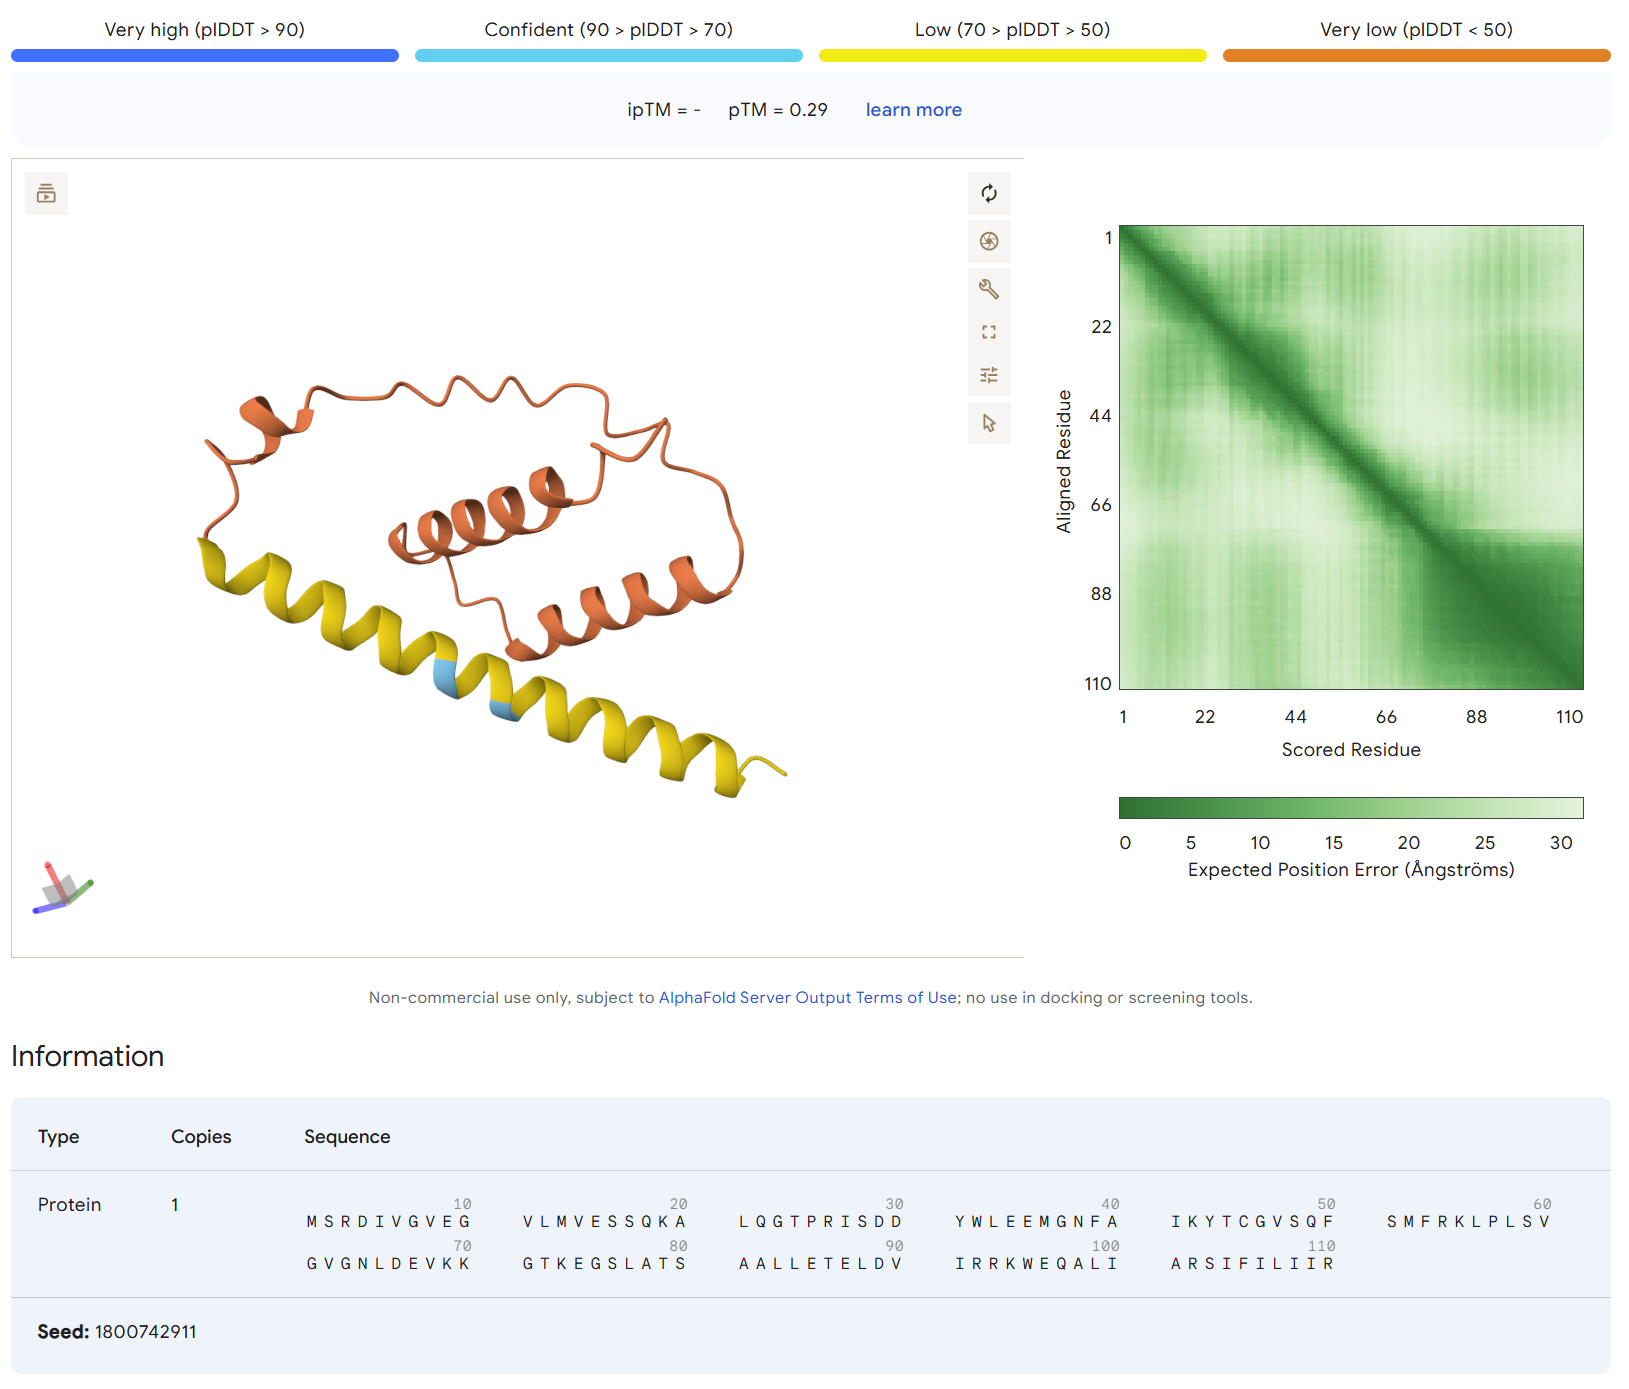

```
By submitting your amino acid sequences to Alphafoldserver you are able to examine a predicted structure and confidence score.
```

**How can you improve upon these results?**

Consider adjusting the following:
- sequence dataset
- smoothing
- normalization
- random number generator seed value

Think creatively about other techniques you can introduce to improve your protein!

## Summary



The advantage of learning the bigram model is because of its simplicity. The disadvantage is that its unable to capture a meaningful representation of amino acid sequences that form a coherent protein as can be seen in the AlphaFold graphic above. A two-dimensional matrix was required to capture bigram information. Thus, a three-dimensional matrix would be needed for three tokens and a four-dimensional matrix for four tokens. As you can see, this scheme is not scalable and so we will need a new paradigm to resolve this issue.

So far you have learned how to:

1. collect sequence data
2. clean and curate protein sequences
3. count thousands of bigrams using the GPU
4. store those counts
5. smooth bigram counts
6. normalize bigram counts into probabilities
7. sample from the distribution to create new protein sequences

The next lesson will introduce **deep learning** so stay tuned!

# Further Reading and Resources

This work was inspired by Demis Hassabis from Google DeepMind and his pioneering work in proteomics and the exquisite machine learning lessons of Andrej Karpathy. Also special mention to the Protein Data Bank who has been invaluable to the molecular biology community by publicly cataloging biological data that is integral to push the field forward.


1. [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo&t=765s) on YouTube where Andrej Karpathy introduces natural language generation with the bigram model in great detail.

2. Visit alphafoldserver's [FAQs](https://alphafoldserver.com/faq#how-can-i-interpret-confidence-metrics-to-check-the-accuracy-of-structures) to evaluate protein structure predictions with AlphaFold3

3. The [Protein Data Bank](https://proteindatabank.com) is a place to discover a variety of freely available biological data resources

